# Exercise for Chapter 2 (Solutions)

In [51]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

register_matplotlib_converters()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARMA

from arch import arch_model

from scipy.stats import ttest_1samp

In [2]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")

### Exercise 1

Consider the exchange rate daily data from December 4, 2006 to November 5, 2010 (Rupee versus Dollar, Pound and Euro), in file exchange_rates_1.csv.
1. Compute the sample average, standard deviation and the first order autocorrelation of daily returns over the entire sample period.
Test if the mean and the first order autocorrelation are significantly different from zero using the tests proposed in Section 2.6.

2. Plot histograms of the returns over the entire sample period; Does the distribution look normal? Test it through Jarque-Bera test in (2.37).

3. Aggregate the data at the weekly level. Repeat (1) and (2) on the aggregated data. Compare the result with the result for the daily level.


#### Part 1

Let's load the data look at a few rows and then plot to see what the data looks like.

In [3]:
fx_prices = pd.read_csv('../datasets/exchange_rates_1.csv',index_col='Date',parse_dates=['Date'])
fx_prices.columns = ['USDINR','GBPINR','EURINR']
fx_prices.round(2).head()

,USDINR,GBPINR,EURINR
Date,,,
2006-12-04,44.59,88.24,59.40
2006-12-05,45.10,89.27,60.17
2006-12-06,44.69,87.95,59.38
2006-12-07,44.66,87.94,59.44
2006-12-08,44.66,87.60,59.34


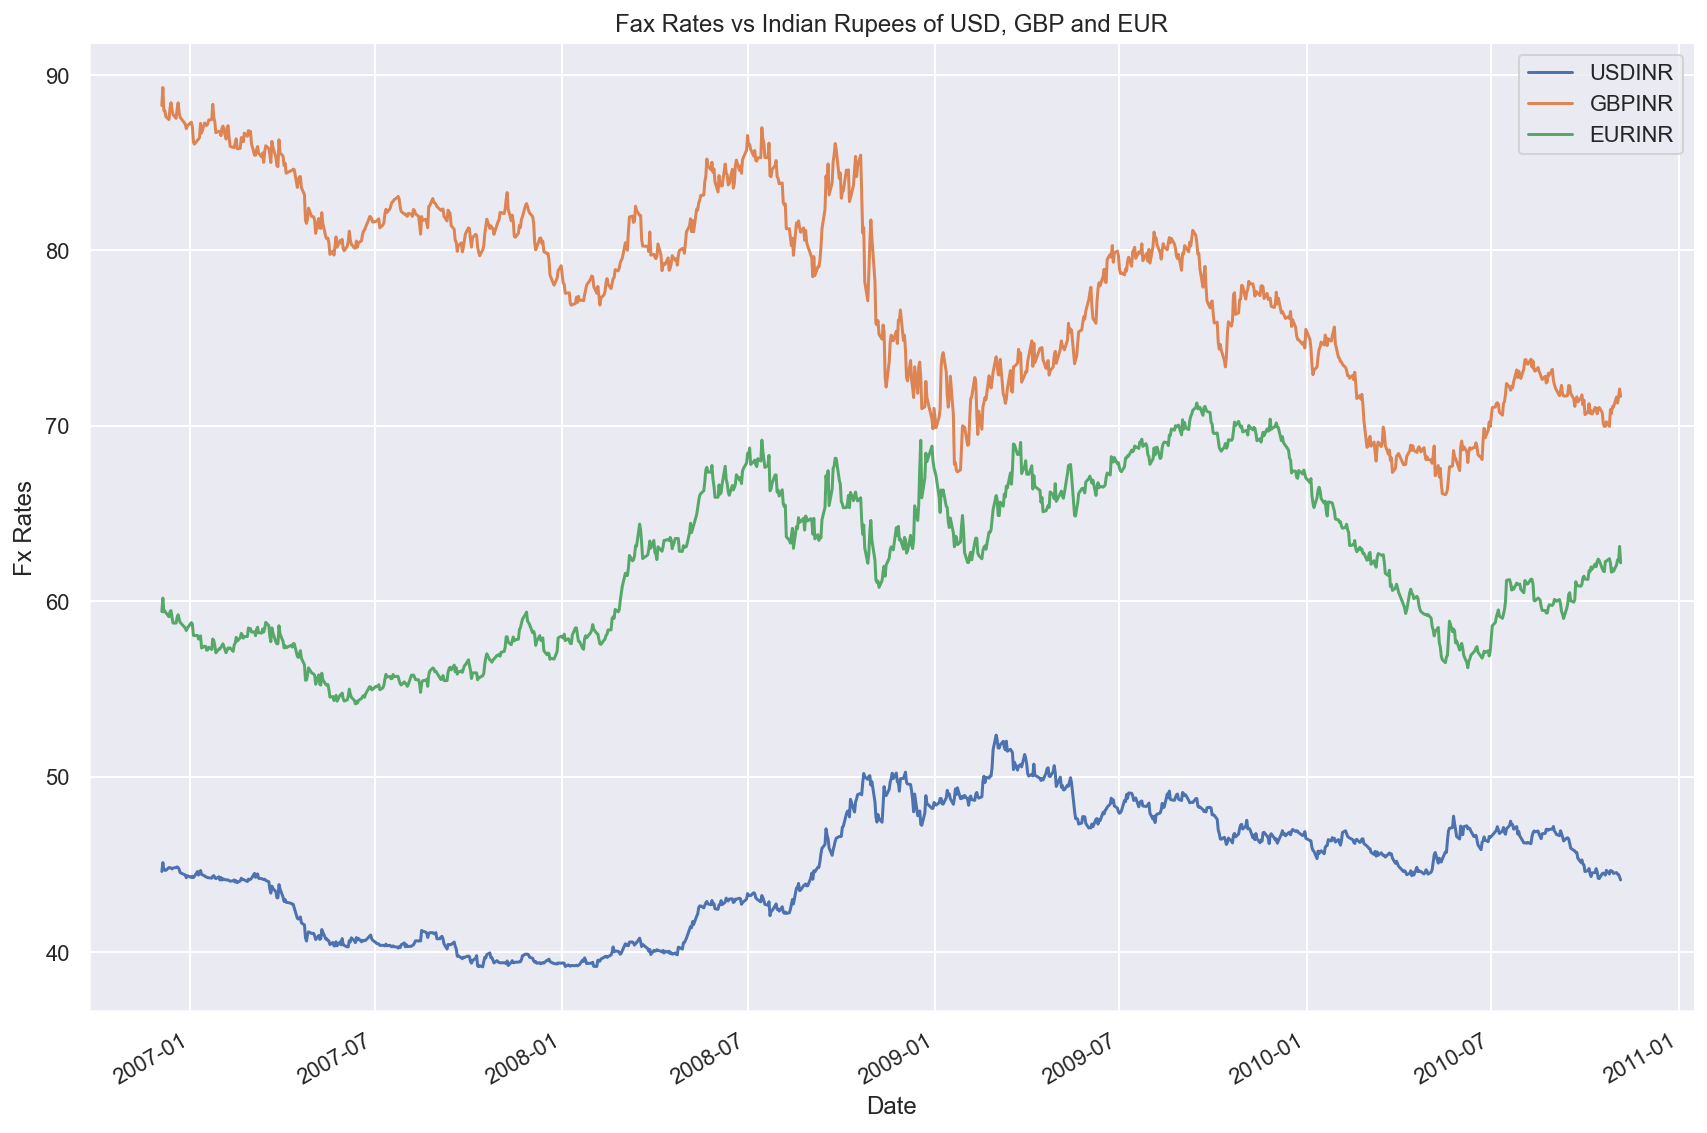

In [4]:
fig,ax = plt.subplots(figsize=(12,8))
_ = fx_prices.plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates vs Indian Rupees of USD, GBP and EUR')
sns.despine()
plt.tight_layout()
plt.show()

Let's generate the returns and have a quick look

In [5]:
fx_returns = fx_prices.pct_change().dropna().round(4)
fx_returns.round(4).head()

,USDINR,GBPINR,EURINR
Date,,,
2006-12-05,0.0114,0.0117,0.0130
2006-12-06,-0.0089,-0.0148,-0.0132
2006-12-07,-0.0008,-0.0001,0.0009
2006-12-08,-0.0000,-0.0038,-0.0016
2006-12-11,0.0036,-0.0019,-0.0039


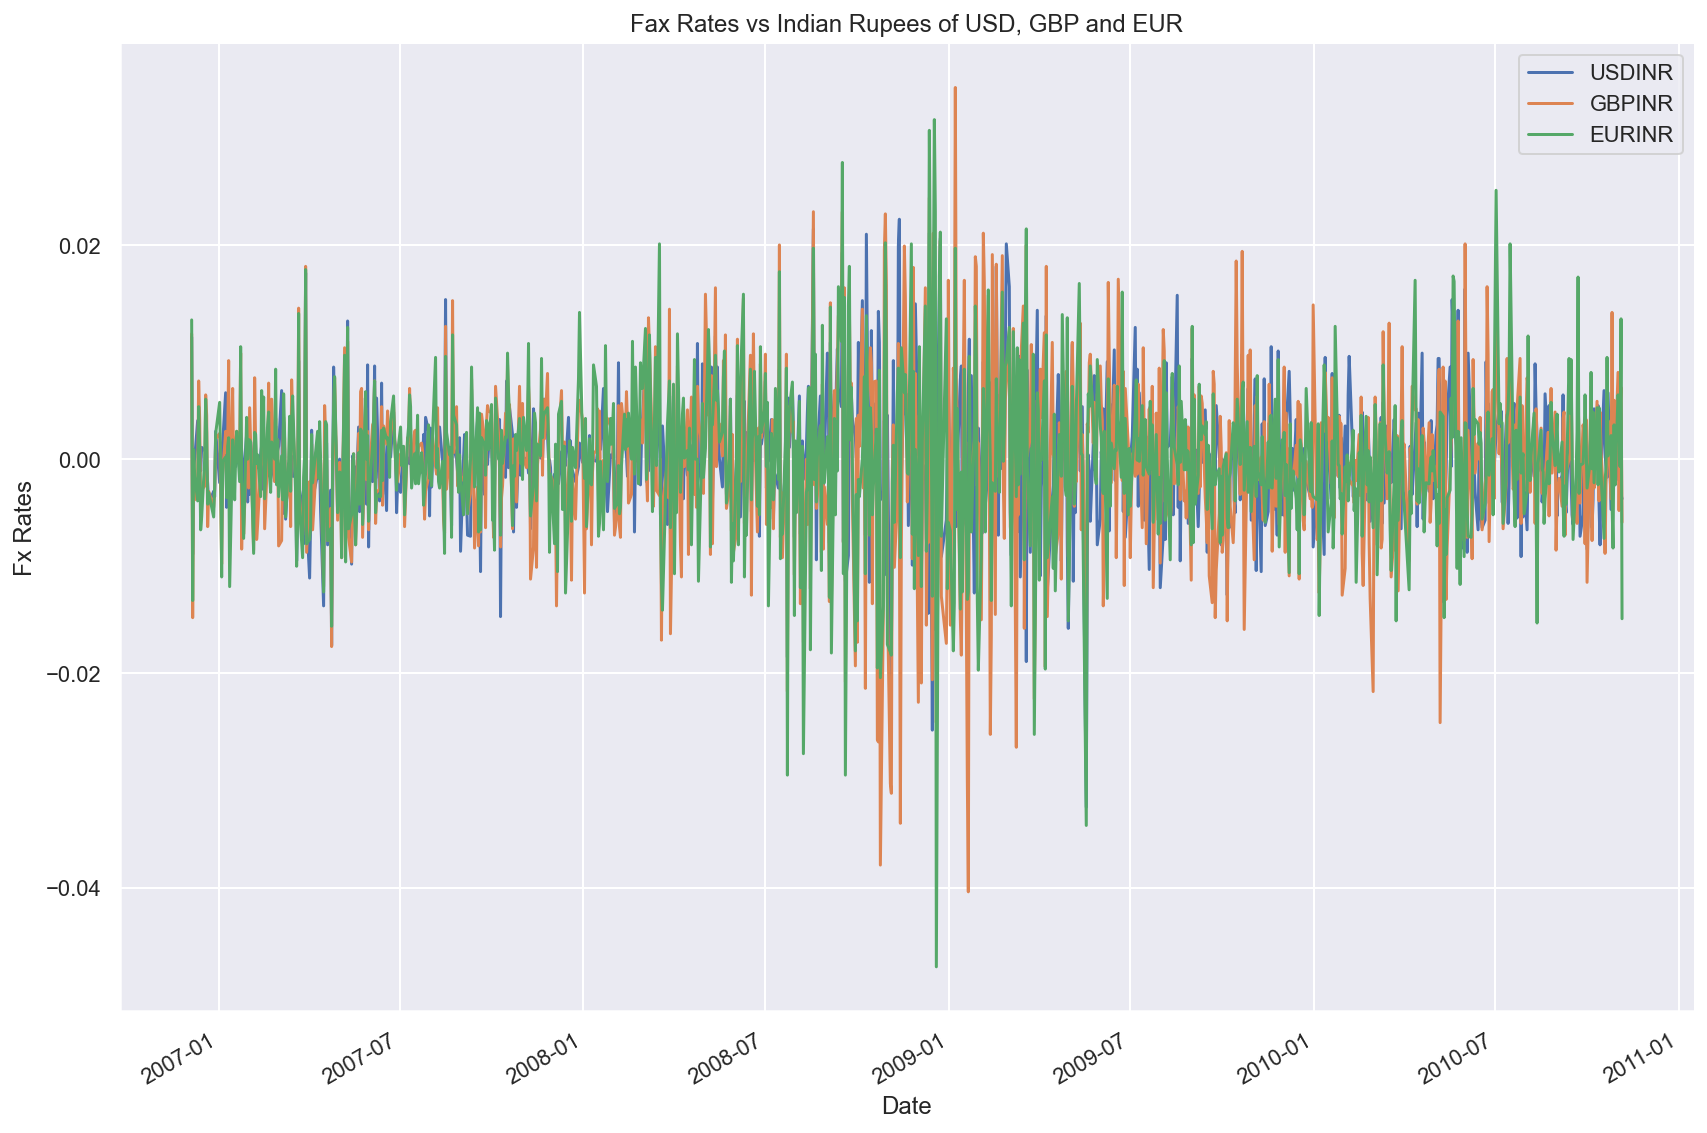

In [6]:
fig,ax = plt.subplots(figsize=(12,8))
_ = fx_returns.plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates vs Indian Rupees of USD, GBP and EUR')
sns.despine()
plt.tight_layout()
plt.show()

Let's review the main statistics of the returns:

In [7]:
stats = pd.concat({'mean':fx_returns.mean(axis=0),'std':fx_returns.std(axis=0),'autocorr':fx_returns.apply(lambda s: s.autocorr(lag=1))},axis=1)
stats

,mean,std,autocorr
USDINR,0.000006,0.005638,-0.047870
GBPINR,-0.000174,0.008085,-0.016840
EURINR,0.000074,0.007261,-0.053214


To test the hypohtesis that the means are zero let's first do a one sample t-test analysis:

In [8]:
ttest_tstats, ttest_pv = ttest_1samp(fx_returns,0)
print(f'p-values for one sample t-test:\n{ttest_pv}')

p-values for one sample t-test:
[0.97496084 0.49723581 0.74677083]


All three p-values are greater than zero, so we don’t have enough evidence to reject the null hypothesis that
mean equals zero.

We then look at 1 lag autocorrelation using the Ljung-Box test for autocorrelation of residuals:

In [9]:
lbox_pvalues = [acorr_ljungbox(fx_returns.loc[:,curr],lags=1)[1][0] for curr in fx_returns.columns]
print(f'p-values for one LJung-Box test:\n{lbox_pvalues}')

p-values for one LJung-Box test:
[0.1301733426993926, 0.5940867526678513, 0.09295756910584677]


All three p-values are greater than zero, so we don’t have enough evidence to reject the null hypothesis that the ACF of lag 1 equals zero

#### Part 2

Let's plot the histograms of returns:

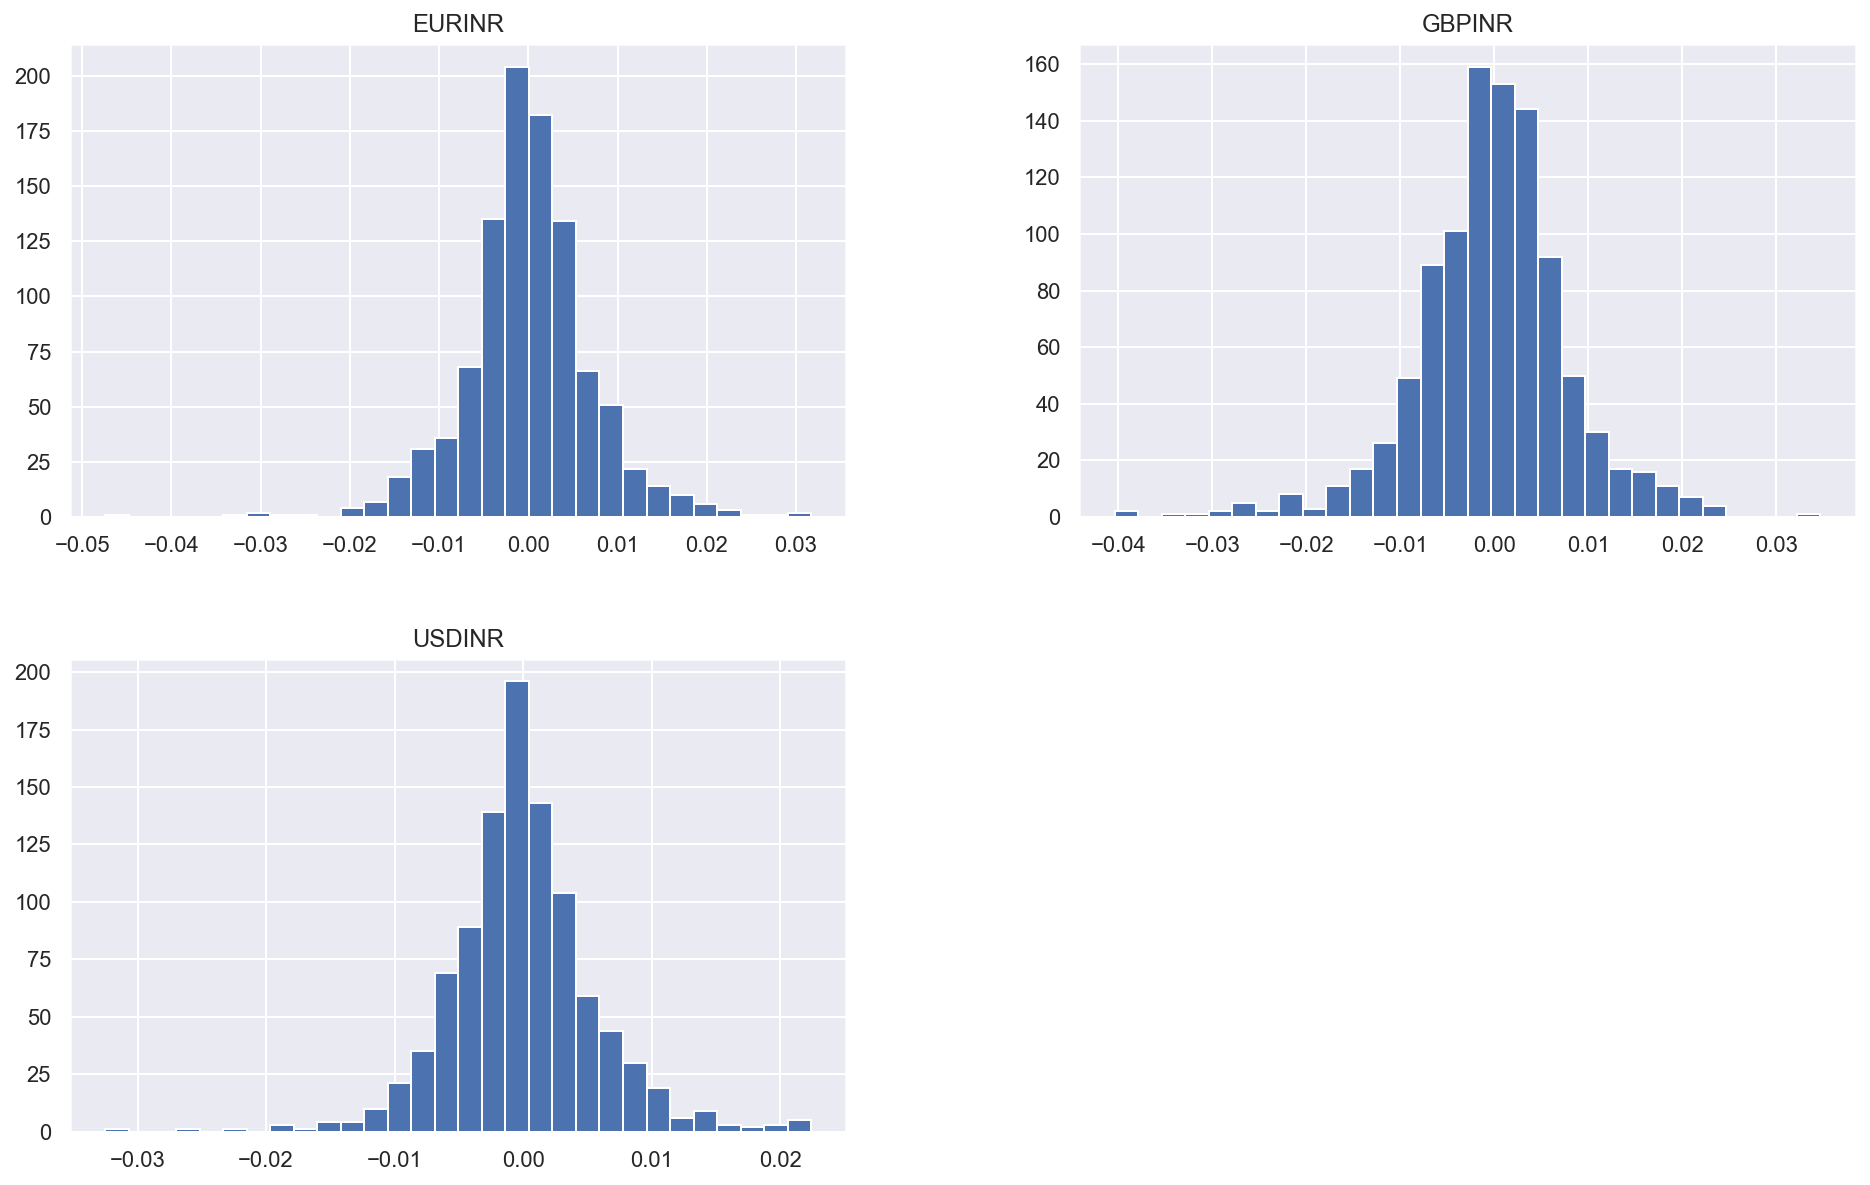

In [10]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
_ = fx_returns.hist(bins=30,ax=ax.reshape(4)[0:3])
_ = ax[1,1].set_visible(False)
plt.show()

The returns do not look particularly normal. Notice the higher than normal kurtosis and skew. We use the Jarque-Bera for goodness of fit

In [11]:
jb_test_pv = jarque_bera(fx_returns)[1]
print(f'p-values for jarque_bera Test:\n{jb_test_pv}')

p-values for jarque_bera Test:
[5.38927612e-085 1.84647412e-066 3.76467431e-140]


The p-values are essentially 0 thus we need to reject the hypothesis that the returns are normal

#### Part 3

Let's resample the data to create a weekly dataset and re-run all out analysis.

In [12]:
fx_weekly_prices = fx_prices.resample('W').first()
fx_weekly_returns = fx_weekly_prices.apply(lambda s: np.log(s) - np.log(s).shift(1),axis=0).dropna()

In [13]:
weekly_stats = pd.concat({'mean':fx_weekly_returns.mean(axis=0),'std':fx_weekly_returns.std(axis=0),'autocorr':fx_weekly_returns.apply(lambda s: s.autocorr(lag=1))},axis=1)
weekly_stats

,mean,std,autocorr
USDINR,-0.000007,0.011966,0.115449
GBPINR,-0.001022,0.016916,-0.123775
EURINR,0.000215,0.014977,-0.059014


In [14]:
ttest_tstats, ttest_pv = ttest_1samp(fx_weekly_returns,0)
print(f'p-values for one sample t-test:\n{ttest_pv}')

p-values for one sample t-test:
[0.99326437 0.38909941 0.83770731]


In [15]:
lbox_pvalues = [acorr_ljungbox(fx_weekly_returns.loc[:,curr],lags=1)[1][0] for curr in fx_returns.columns]
print(f'p-values for one LJung-Box test:\n{lbox_pvalues}')

p-values for one LJung-Box test:
[0.09685847108112841, 0.07660584576684498, 0.39617349788492895]


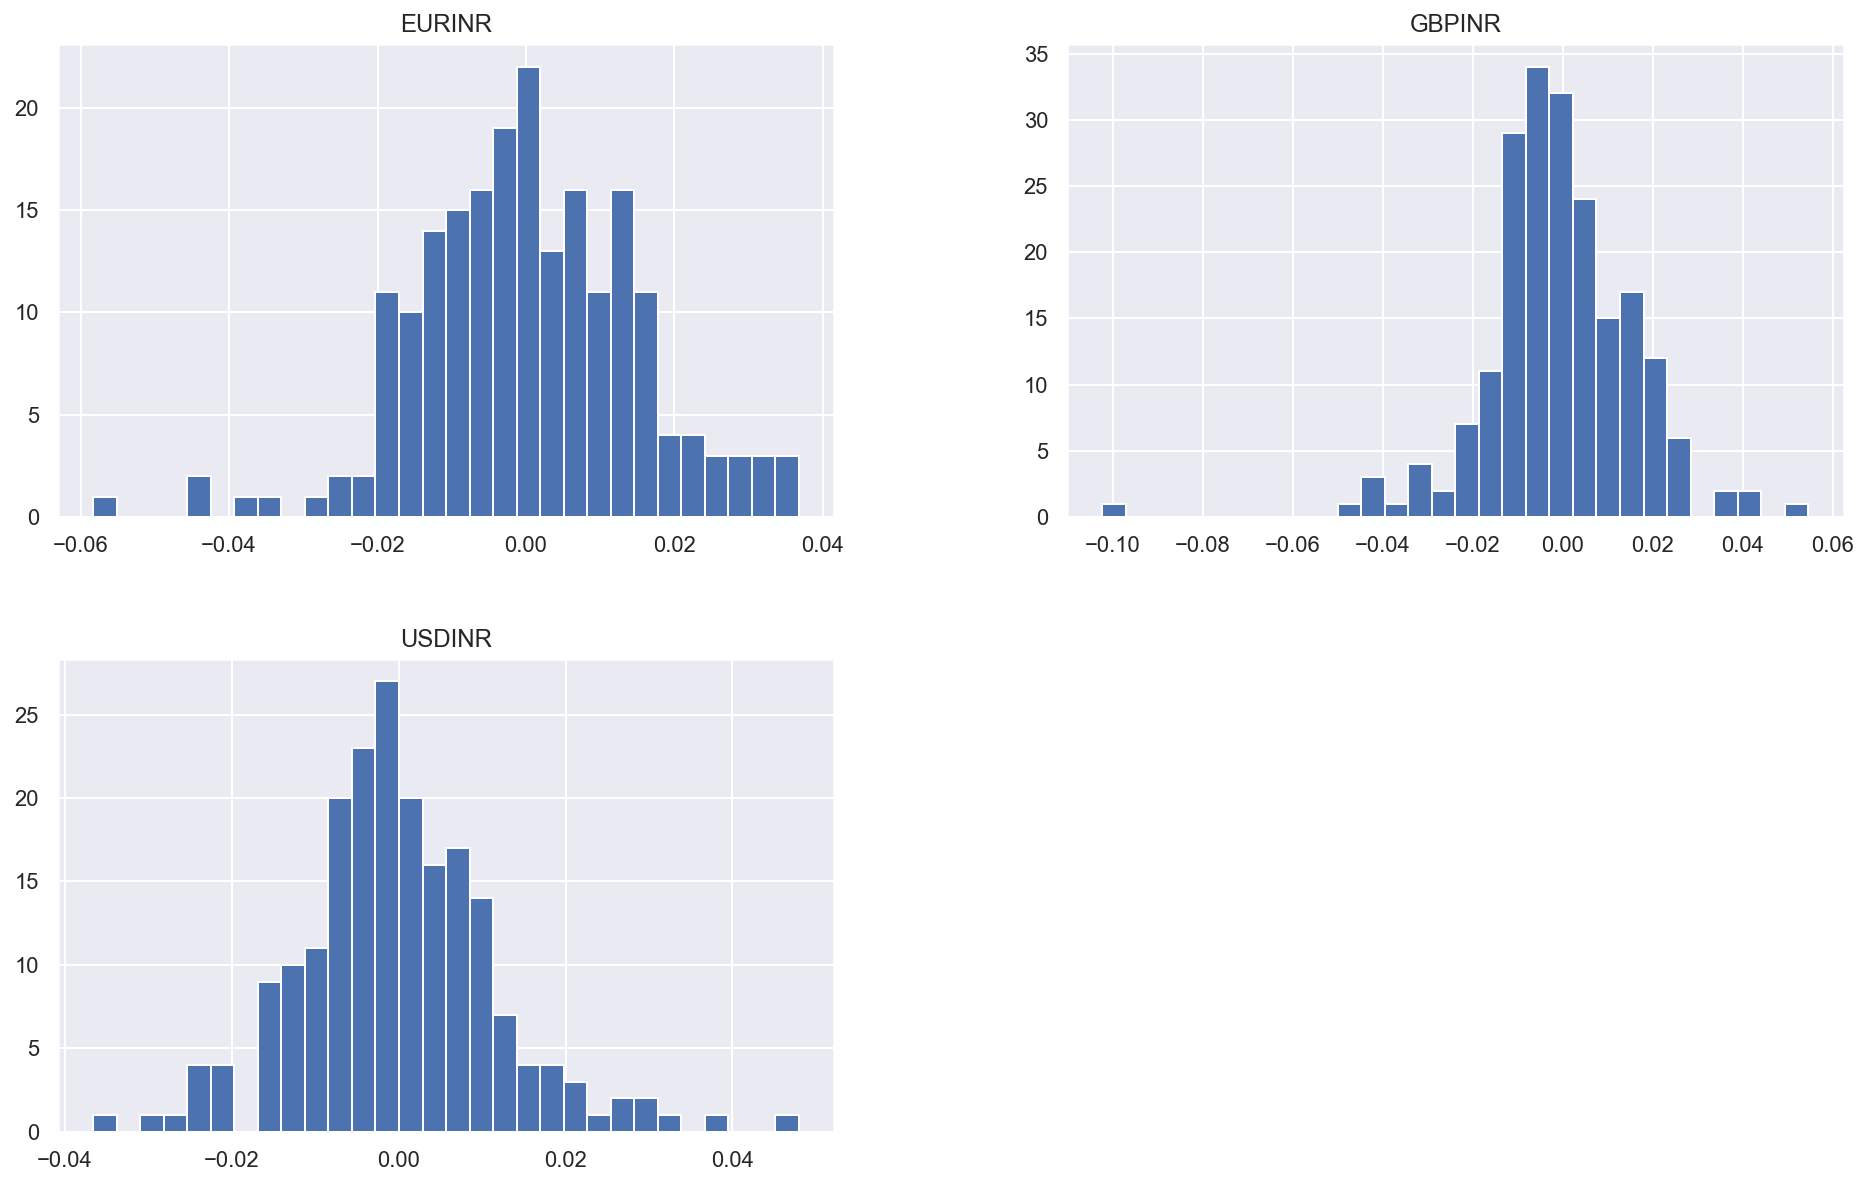

In [16]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
_ = fx_weekly_returns.hist(bins=30, ax=ax.reshape(4)[0:3])
_ = ax[1,1].set_visible(False)
plt.show()

In [17]:
jb_test_pv = jarque_bera(fx_weekly_returns)[1]
print(f'p-values for jarque_bera Test:\n{jb_test_pv}')

p-values for jarque_bera Test:
[2.34731094e-07 2.35545812e-77 4.07331729e-03]


The analysis confirms that the results still hold if we look at weekly data:

- Cannot reject mean different than 0
- Cannot reject that there is no autocorrelation on lag 1
- Must reject that the sample is normally distributed

### Exercise 2

For the returns of all three time series in Problem 1, construct...
1. ARMA models for the returns. Identify the model structure via ACF and PACF.
2. GARCH models for the squared returns; compare the model coefficients for the three series. Comment on the difference, if any.
3. Is there a co-movement among the three exchange-rate series? To make the plots on a comparable scale, convert the starting points of the series unity. Does the
co-movement vary over different time regimes? (Back up your claim with solid analysis.) Identify the transition states and speculate how you can exploit this for
trading decisions.

#### Part 1 ARMA Modeling

##### USDINR

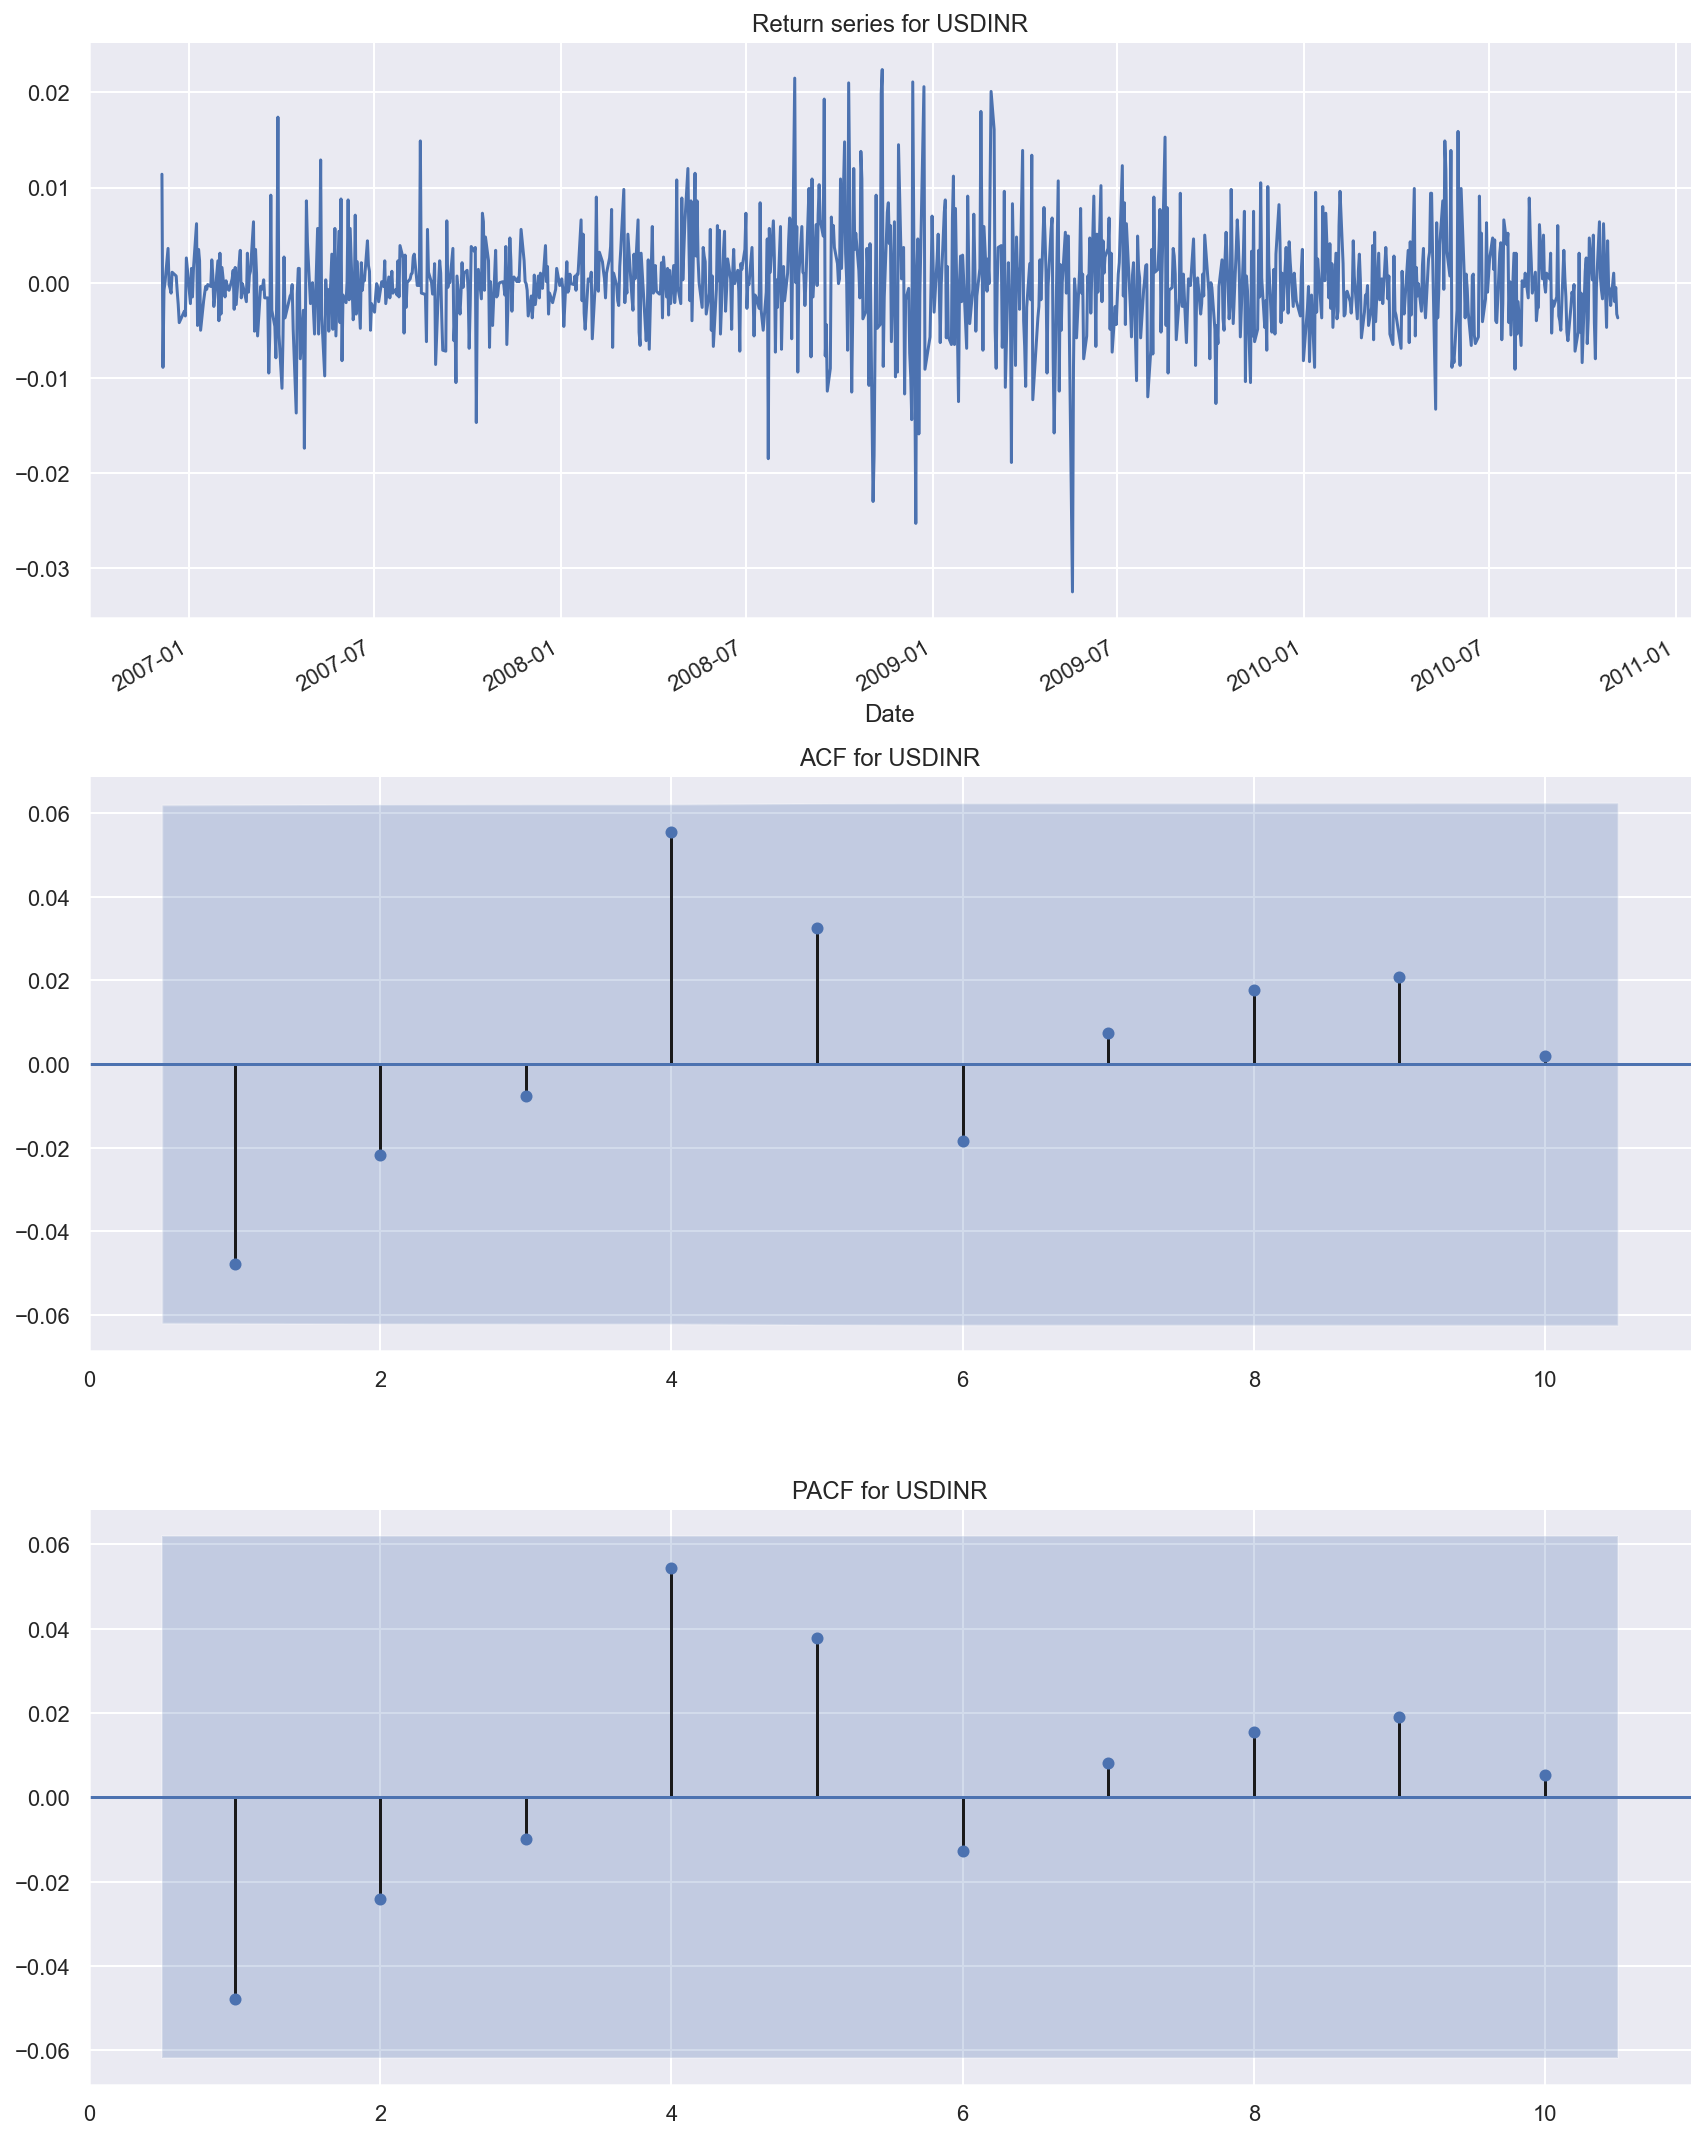

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.USDINR.plot(ax=ax1,title='Return series for USDINR')
_ = plot_acf(fx_returns.USDINR, ax=ax2,zero=False,alpha=0.05,lags=10,title='ACF for USDINR')
_ = plot_pacf(fx_returns.USDINR, ax=ax3,zero=False,alpha=0.05,lags=10,title='PACF for USDINR')
sns.despine()
plt.tight_layout()
plt.show()

The ACF and PACF show little or more significance at any lag.
Returns look little more than white noise so no real point running an ARMA modeling.

##### GBPINR

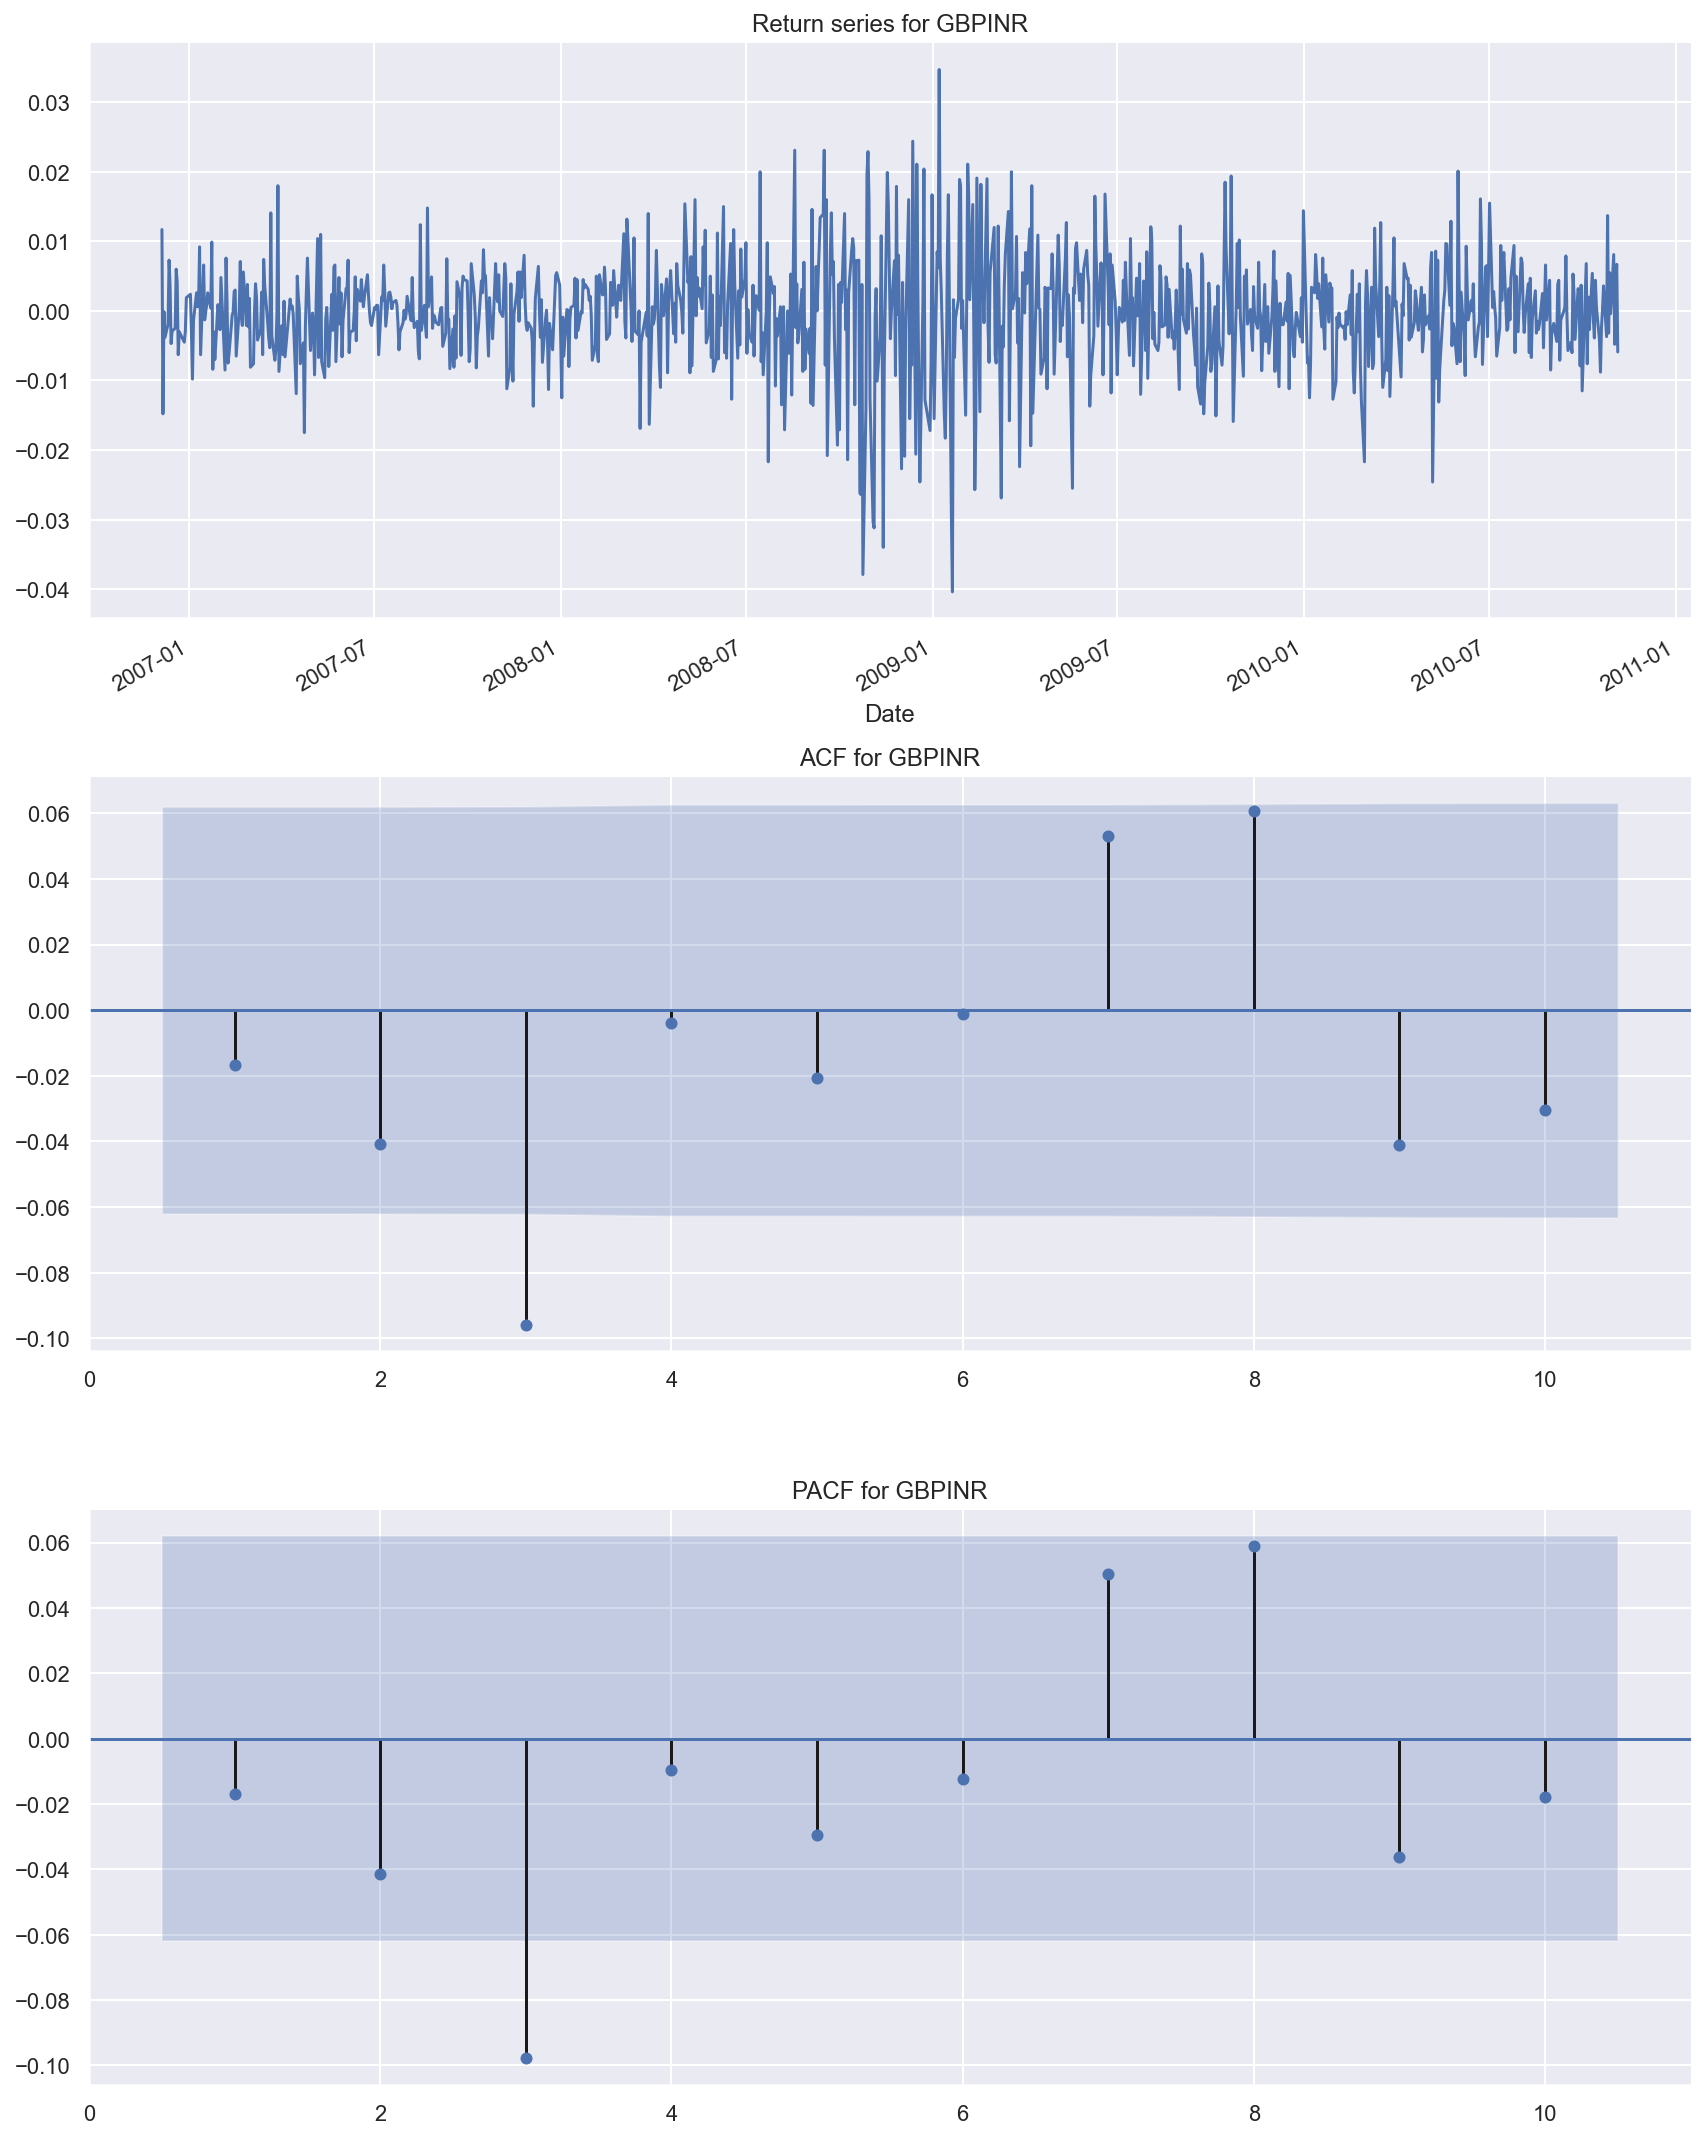

In [28]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.GBPINR.plot(ax=ax1,title='Return series for GBPINR')
_ = plot_acf(fx_returns.GBPINR, ax=ax2,zero = False,alpha=0.05,lags=10,title='ACF for GBPINR')
_ = plot_pacf(fx_returns.GBPINR, ax=ax3, zero = False,alpha=0.05,lags=10,title='PACF for GBPINR')
sns.despine()
plt.tight_layout()
plt.show()

The series show releavant ACF at lag 3 and so does the PACF. This would imply an ARMA(3,3). We are using the ARMA implementation of the stats model package

In [48]:
results = ARMA(fx_returns.GBPINR,(3,3)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 GBPINR   No. Observations:                 1001
Model:                     ARMA(3, 3)   Log Likelihood                3409.325
Method:                       css-mle   S.D. of innovations              0.008
Date:                Mon, 03 Aug 2020   AIC                          -6802.650
Time:                        12:10:31   BIC                          -6763.380
Sample:                             0   HQIC                         -6787.726
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.000     -0.829      0.407      -0.001       0.000
ar.L1.GBPINR    -0.2366      0.227     -1.044      0.296      -0.681       0.208
ar.L2.GBPINR    -0.1715      0.191     -0.900      0.368      -0.545       0.202
ar.L3.GBPINR     0.3563      0.239      1.491      0.136      -0.112       0.824
ma.L1.GBPINR     0.2112      0.215      0.984      0.325      -0.209       0.632
ma.L2.GBPINR     0.1231      0.181      0.678      0.498      -0.233       0.479
ma.L3.GBPINR    -0.4626      0.228     -2.031      0.042      -0.909      -0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6404           -1.0875j            1.2621           -0.3347
AR.2           -0.6404           +1.0875j            1.2621            0.3347
AR.3            1.7621           -0.0000j            1.7621           -0.0000
MA.1           -0.6233           -1.0201j            1.1954           -0.3373
MA.2           -0.6233           +1.0201j            1.1954            0.3373
MA.3            1.5126           -0.0000j            1.5126           -0.0000
-----------------------------------------------------------------------------
"""

TODO: Provide Commentary on results

##### EURINR

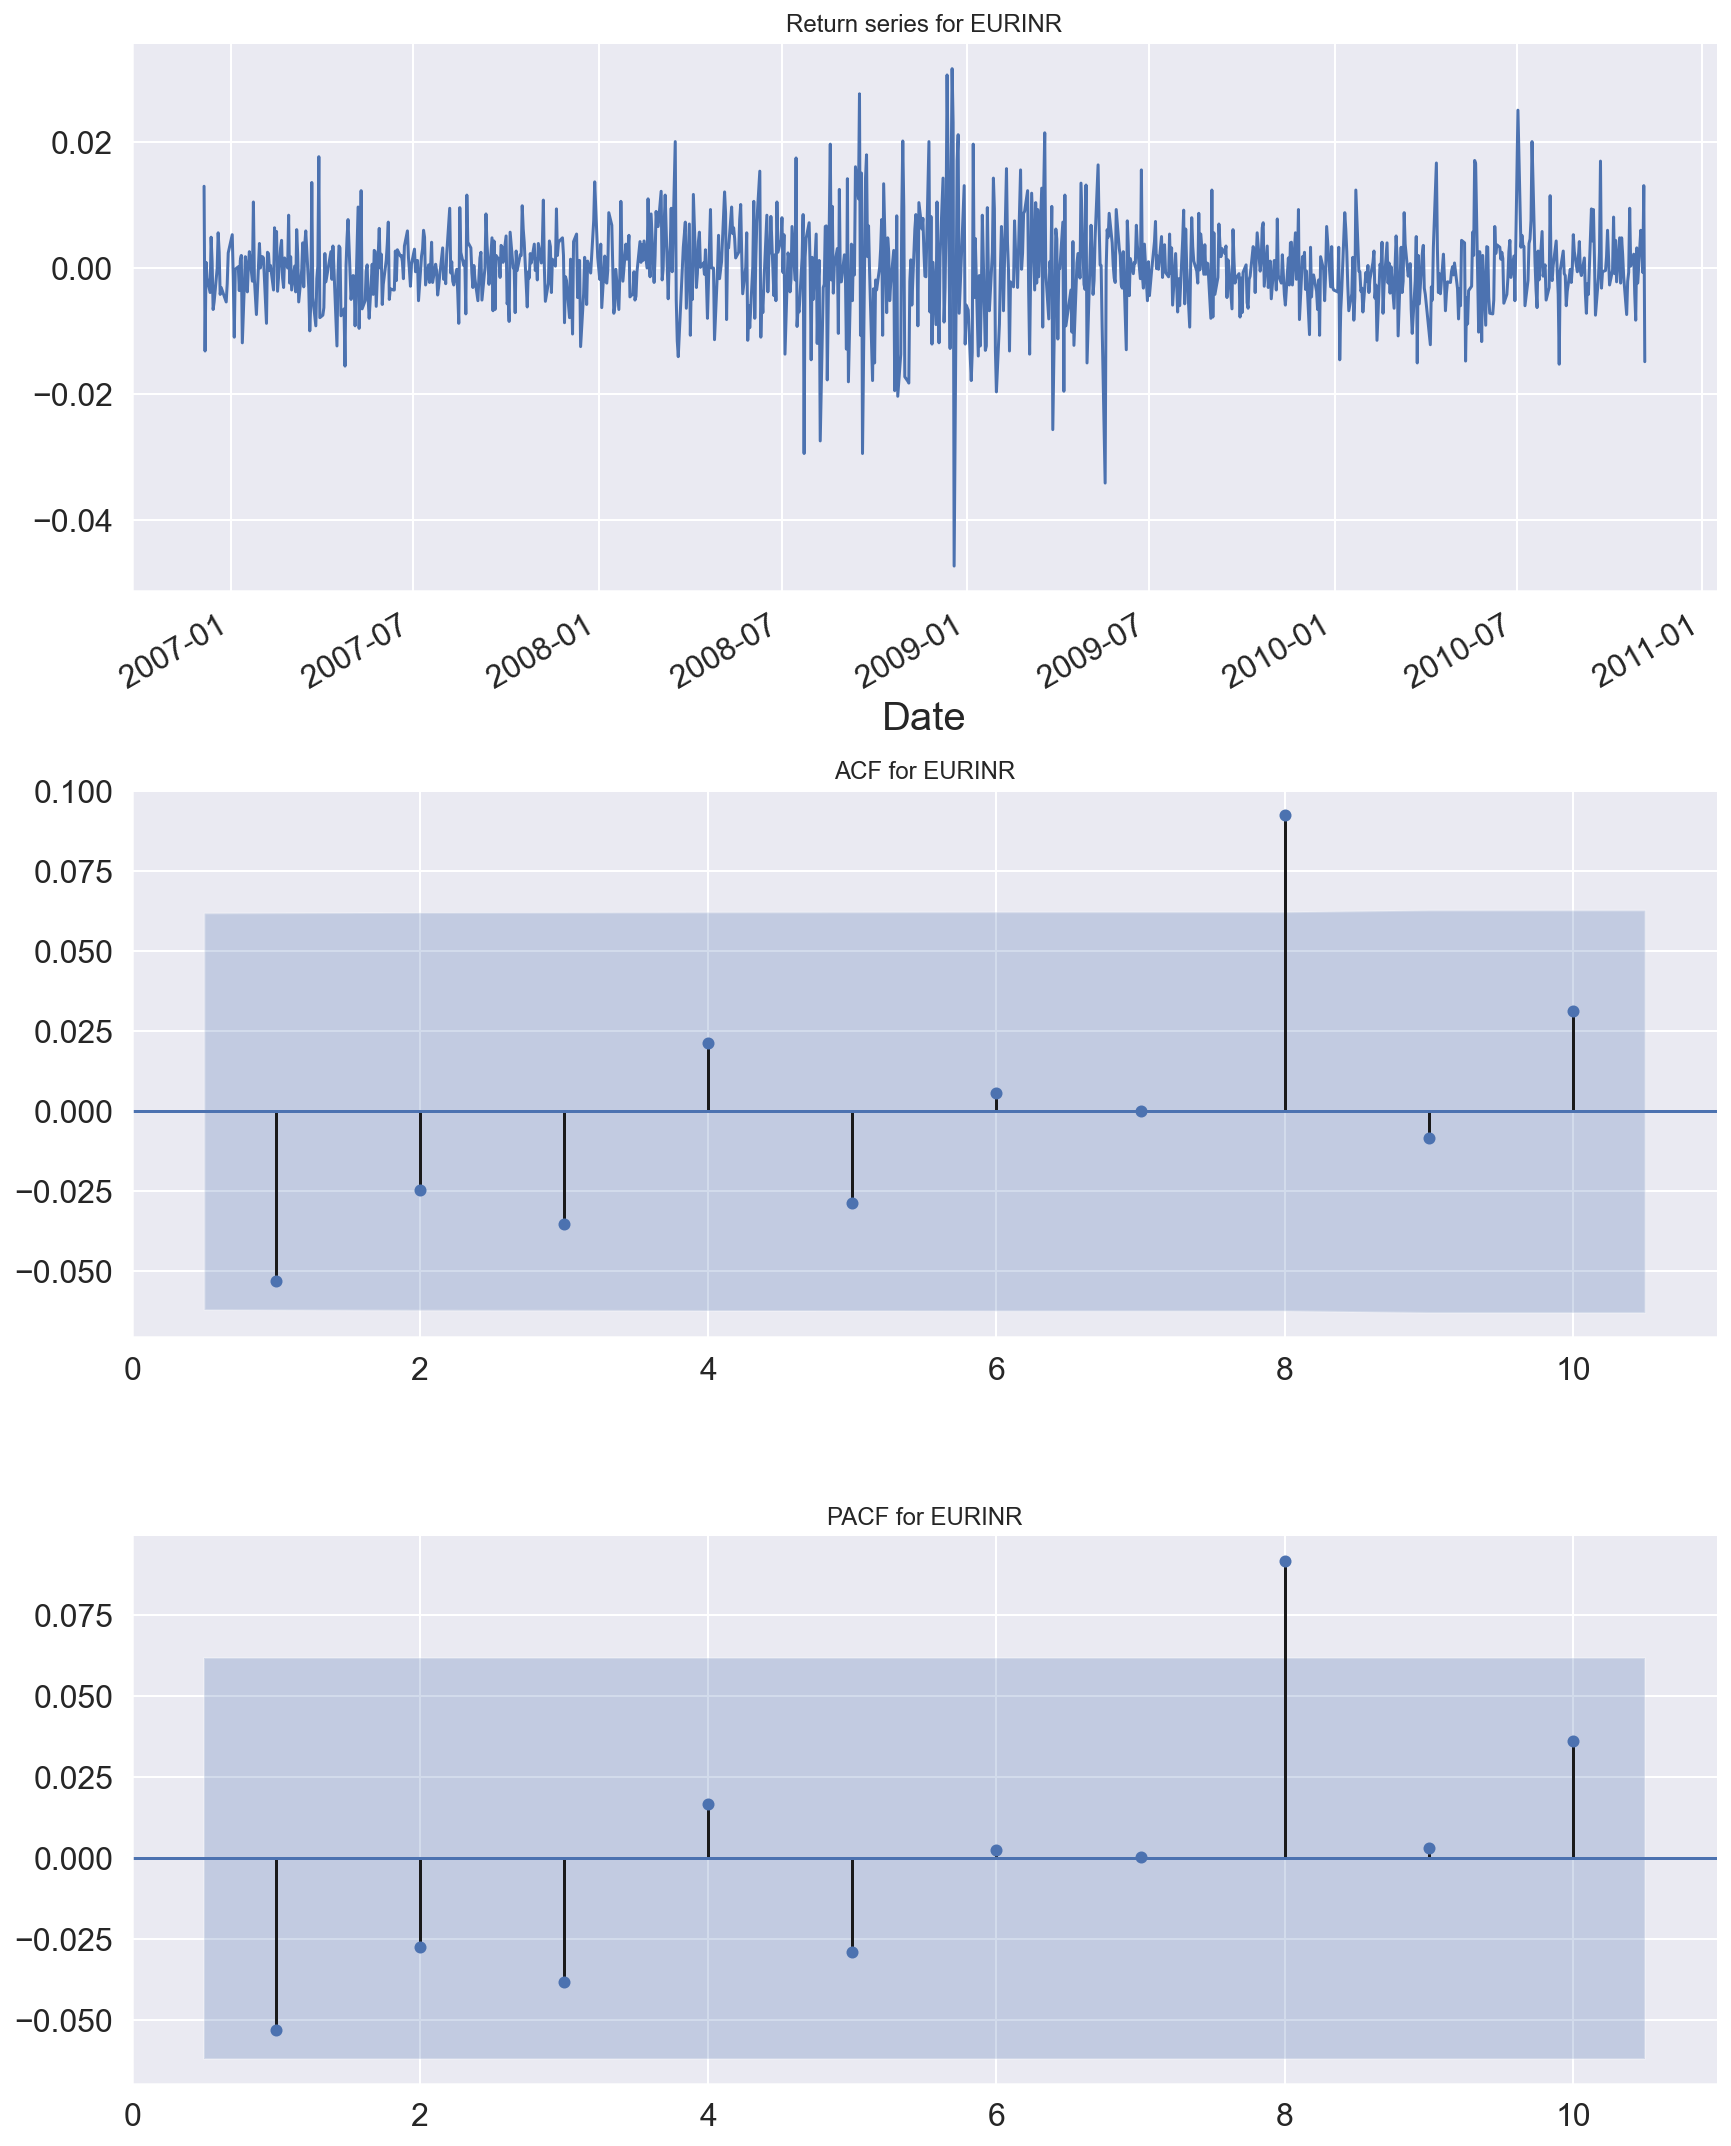

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.EURINR.plot(ax=ax1,title='Return series for EURINR')
_ = plot_acf(fx_returns.EURINR, ax=ax2,zero = False,alpha=0.05,lags=10,title='ACF for EURINR')
_ = plot_pacf(fx_returns.EURINR, ax=ax3, zero = False,alpha=0.05,lags=10,title='PACF for EURINR')
sns.despine()
plt.tight_layout()
plt.show()



The ACF and PACF show only significance at lag 7 so very weak dependency. No real point running an ARMA modeling.

#### Part 2 GARCH Modeling


We'll use the arch package to fit the time series


##### USDINR

In [54]:
am = arch_model(fx_returns.USDINR)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.346434436222032e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.42753773409707e+26
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.9721936693701143e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2083615611722199.2
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.65091332932914e+20
Iteration:      6,   Func. Count:     76,   Neg. LLF: 8795446818084500.0
Iteration:      7,   Func. Count:     91,   Neg. LLF: 3.878710911402228e+20
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6733602488270100.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3854.3176772261477
            Iterations: 12
            Function evaluations: 113
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 USDINR   R-squared:                      -0.000
Mean Model:             Constant 